In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Datasets/Brain Tumor MRI dataset.zip' -d '/content/'

In [3]:
import torch
import torch.nn as nn
from torch import tensor, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import os, time, csv, copy
from PIL import Image
import pandas as pd
import torchvision
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = [p_left, p_top, p_right, p_bottom]
        return F.pad(image, padding, 0, 'constant')

In [6]:
target_image_size = (512, 512)
transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(target_image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [10]:
def train_model(model, criterion, optimizer, scheduler, data_loaders, dataset_sizes, num_epochs=25, log_interval=5, checkpoint_path=""):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    least_loss = np.Inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            if phase == 'val' and not ((epoch + 1) % log_interval):
              continue

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < least_loss:
                least_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model_ft.state_dict(), os.path.join(checkpoint_path, "model_best.pt"))
            torch.save(model_ft.state_dict(), os.path.join(checkpoint_path, "model_last.pt"))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(least_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
DATA_DIR = '/content/Training'
BATCH_SIZE = 32

In [15]:
def train_val_split(dataset, p=0.4):
  dataset_size = len(dataset)
  train_size = (1 - p) * dataset_size
  train_size = int(train_size)
  val_size = dataset_size - train_size 

  return random_split(dataset, [train_size, val_size])

In [16]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

In [18]:
len(dataset)

5712

In [19]:
# Load dataset
train_set, val_set = train_val_split(dataset)
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

data_loaders = {'train': trainloader,'val': valloader}
dataset_sizes = {'train': len(train_set),'val': len(val_set)}
CLASS_NAMES =  dataset.classes

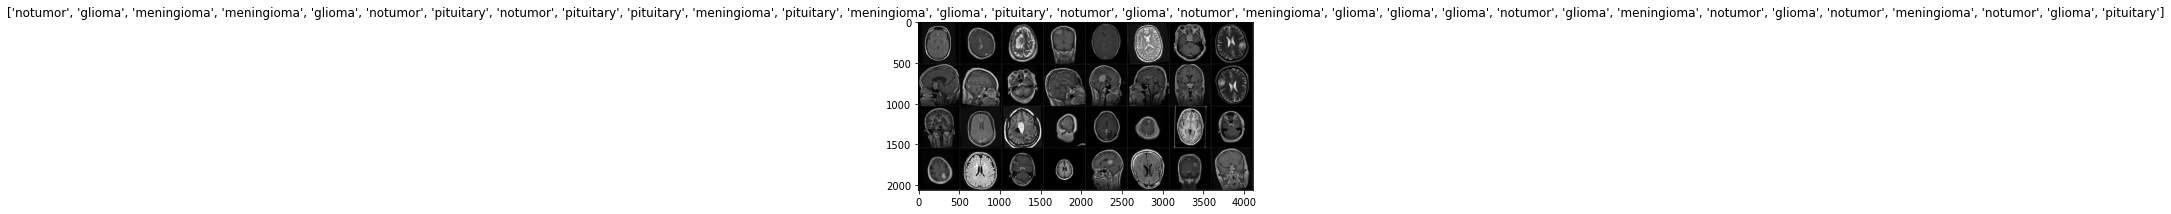

In [20]:
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASS_NAMES[x] for x in classes])


In [21]:
EPOCHS = 20
LOG_INTERVAL = 300
NUM_CLASSES = len(CLASS_NAMES)
CHECKPOINT_DIR = '/content/drive/MyDrive/Brain Tumor MRI Classifier'

In [22]:
# Load model

# model_ft = models.wide_resnet101_2(pretrained=True)
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [23]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       data_loaders,
                       dataset_sizes,
                       num_epochs=25, 
                       log_interval=LOG_INTERVAL, 
                       checkpoint_path=CHECKPOINT_DIR)

Epoch 0/24
----------
train Loss: 0.3414 Acc: 0.8801
val Loss: 0.3721 Acc: 0.8503

Epoch 1/24
----------
train Loss: 0.2135 Acc: 0.9262
val Loss: 0.2882 Acc: 0.9077

Epoch 2/24
----------
train Loss: 0.1858 Acc: 0.9381
val Loss: 0.1192 Acc: 0.9659

Epoch 3/24
----------
train Loss: 0.1339 Acc: 0.9527
val Loss: 0.2785 Acc: 0.9212

Epoch 4/24
----------
train Loss: 0.0811 Acc: 0.9737
val Loss: 0.0707 Acc: 0.9772

Epoch 5/24
----------
train Loss: 0.0544 Acc: 0.9828
val Loss: 0.1304 Acc: 0.9567

Epoch 6/24
----------
train Loss: 0.0600 Acc: 0.9793
val Loss: 0.1589 Acc: 0.9492

Epoch 7/24
----------
train Loss: 0.0404 Acc: 0.9877
val Loss: 0.0545 Acc: 0.9864

Epoch 8/24
----------
train Loss: 0.0238 Acc: 0.9936
val Loss: 0.0530 Acc: 0.9869

Epoch 9/24
----------
train Loss: 0.0193 Acc: 0.9959
val Loss: 0.0490 Acc: 0.9873

Epoch 10/24
----------
train Loss: 0.0179 Acc: 0.9947
val Loss: 0.0451 Acc: 0.9873

Epoch 11/24
----------
train Loss: 0.0113 Acc: 0.9977
val Loss: 0.0462 Acc: 0.9895

Ep

In [24]:
def predict(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

In [25]:
# Load model

# model_ft = models.wide_resnet101_2(pretrained=True)
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [26]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/DK/model_best.pt'))

<All keys matched successfully>

In [41]:
def do_test(add='/content/Testing'):
  f = open('output.csv', 'w')
  writer = csv.writer(f)
  writer.writerow(['name', 'predicted', 'real_label'])
  for class_name in os.listdir(add):
    test_files_path = os.path.join(add, class_name)

    model_ft.eval()
    with torch.no_grad():
        for category_idx, filename in enumerate(os.listdir(test_files_path)):
            image_file = os.path.join(test_files_path, filename)
            img = Image.open(image_file).convert('RGB')
            img.load()
            
            trans_img = torch.unsqueeze(transform(img), 0).to(device)
            logits = model_ft(trans_img)
            
            _, predicted = torch.max(logits, 1)
            
            idx_pred = predicted.detach().item()
            cat_pred = list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(idx_pred)]
            row = [filename, cat_pred, class_name]
            writer.writerow(row)
          
  f.close()

In [42]:
do_test(add='/content/Testing')

In [57]:
out = pd.read_csv('/content/output.csv')

In [58]:
out

,name,predicted,real_label
0,Te-pi_0030.jpg,pituitary,pituitary
1,Te-pi_0076.jpg,pituitary,pituitary
2,Te-pi_0135.jpg,pituitary,pituitary
3,Te-pi_0286.jpg,pituitary,pituitary
4,Te-pi_0228.jpg,pituitary,pituitary
...,...,...,...
1306,Te-gl_0274.jpg,glioma,glioma
1307,Te-gl_0171.jpg,glioma,glioma
1308,Te-gl_0186.jpg,glioma,glioma
1309,Te-gl_0079.jpg,glioma,glioma


In [59]:
correct_predictions = (out['predicted'] == out['real_label'])

In [60]:
correct_predictions

0       True
1       True
2       True
3       True
4       True
        ... 
1306    True
1307    True
1308    True
1309    True
1310    True
Length: 1311, dtype: bool

In [61]:
out['correctly_predicted'] = 0
out.loc[correct_predictions,'correctly_predicted'] = 1 

In [62]:
out

,name,predicted,real_label,correctly_predicted
0,Te-pi_0030.jpg,pituitary,pituitary,1
1,Te-pi_0076.jpg,pituitary,pituitary,1
2,Te-pi_0135.jpg,pituitary,pituitary,1
3,Te-pi_0286.jpg,pituitary,pituitary,1
4,Te-pi_0228.jpg,pituitary,pituitary,1
...,...,...,...,...
1306,Te-gl_0274.jpg,glioma,glioma,1
1307,Te-gl_0171.jpg,glioma,glioma,1
1308,Te-gl_0186.jpg,glioma,glioma,1
1309,Te-gl_0079.jpg,glioma,glioma,1


In [66]:
sum(out['correctly_predicted']) / len(out)

0.9877955758962624

In [63]:
out.to_csv('answer.csv', index=False)